# p(t) and eps(t) analysis for eps-greedy search

This notebook computes and plots `p(t)` and `eps(t)` (separately), using only complete runs.

It includes:
- averages across runs
- curves by prompt
- curves separated by reward function (scorer)


## Definitions
For each timestep `t`, using all `candidate_eval` rows in that timestep:
- `eps(t) = mean(is_global_candidate)`
  - fraction of candidates at timestep `t` that are global/fresh draws
- `p(t) = mean(winner_is_global)`
  - fraction of candidate rows at timestep `t` whose winning candidate came from the global set

Reward function is taken from `run_meta.scorer` (for example `clip`, `brightness`, `compressibility`).

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Adjust glob(s) to include all experiments you want in the comparison.
LOG_GLOB = Path('../logs/search_stats').glob('*.jsonl')

In [3]:
def load_run(path: Path) -> tuple[pd.DataFrame, dict] | tuple[None, None]:
    run_meta = None
    has_run_end = False
    rows = []

    with path.open('r', encoding='utf-8') as f:
        first_line = f.readline()
        if not first_line.strip():
            return None, None
        first = json.loads(first_line)
        lines = [first] + [json.loads(line) for line in f if line.strip()]

    for event in lines:
        et = event.get('event_type')
        if et == 'run_meta':
            run_meta = event.get('run_meta', {})
        elif et == 'candidate_eval':
            rows.append({
                'run_file': path.name,
                'prompt': event.get('prompt'),
                'prompt_index': None if run_meta is None else run_meta.get('prompt_index'),
                'backend': None if run_meta is None else run_meta.get('backend'),
                'method': None if run_meta is None else run_meta.get('method'),
                'reward_fn': None if run_meta is None else run_meta.get('scorer'),
                'sample_idx': int(event.get('sample_idx', 0)),
                'timestep_idx': int(event['timestep_idx']),
                'timestep_value': float(event.get('timestep_value', float('nan'))),
                'local_iter_idx': int(event['local_iter_idx']),
                'is_global_candidate': bool(event['is_global_candidate']),
                'winner_is_global': bool(event['winner_is_global']),
                'score': float(event['score']),
                'winner_score': float(event['winner_score']),
            })
        elif et == 'run_end':
            has_run_end = True

    df = pd.DataFrame(rows)

    meta = {
        'run_file': path.name,
        'prompt': None if run_meta is None else run_meta.get('prompt'),
        'prompt_index': None if run_meta is None else run_meta.get('prompt_index'),
        'backend': None if run_meta is None else run_meta.get('backend'),
        'method': None if run_meta is None else run_meta.get('method'),
        'reward_fn': None if run_meta is None else run_meta.get('scorer'),
        'N': None if run_meta is None else run_meta.get('params', {}).get('N'),
        'K': None if run_meta is None else run_meta.get('params', {}).get('K'),
        'has_run_end': has_run_end,
        'max_timestep_idx': int(df['timestep_idx'].max()) if not df.empty else -1,
        'num_candidate_rows': int(len(df)),
    }

    # Full-search criterion (currently SD eps-greedy convention):
    # run_end + reached timestep 49 + reached local_iter K-1 at each timestep.
    is_complete = meta['has_run_end']
    if is_complete and meta['backend'] == 'sd' and meta['method'] == 'eps_greedy':
        expected_last_t = 49
        is_complete = meta['max_timestep_idx'] >= expected_last_t
        if is_complete and meta['K'] is not None and not df.empty:
            per_t_max_k = df.groupby('timestep_idx')['local_iter_idx'].max()
            required_k = int(meta['K']) - 1
            for t in range(expected_last_t + 1):
                if t not in per_t_max_k.index or int(per_t_max_k.loc[t]) < required_k:
                    is_complete = False
                    break

    meta['is_complete_full_search'] = bool(is_complete)
    return df, meta

In [4]:
all_rows = []
all_meta = []

for p in sorted(LOG_GLOB):
    run_df, run_meta = load_run(p)
    if run_df is None:
        continue
    all_rows.append(run_df)
    all_meta.append(run_meta)

events_df = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
meta_df = pd.DataFrame(all_meta)

meta_df[['run_file', 'backend', 'method', 'reward_fn', 'prompt_index', 'has_run_end', 'max_timestep_idx', 'is_complete_full_search']].head(20)

,run_file,backend,method,reward_fn,prompt_index,has_run_end,max_timestep_idx,is_complete_full_search
0,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,0,True,49,True
1,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,0,True,49,True
2,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,1,True,49,True
3,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,1,True,49,True
4,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,2,True,49,True
5,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,2,True,49,True
6,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,3,True,49,True
7,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,3,True,49,True
8,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,4,True,49,True
9,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,sd,eps_greedy,clip,4,True,49,True


In [5]:
meta_df.groupby(['backend', 'method', 'reward_fn'])['run_file'].count().rename('num_runs').reset_index()

,backend,method,reward_fn,num_runs
0,sd,eps_greedy,clip,42


In [6]:
# Focus on complete SD eps-greedy runs.
analysis_meta = meta_df[(meta_df['backend'] == 'sd') & (meta_df['method'] == 'eps_greedy') & (meta_df['is_complete_full_search'])].copy()
complete_run_files = set(analysis_meta['run_file'])
analysis_df = events_df[events_df['run_file'].isin(complete_run_files)].copy()

step_stats = (
    analysis_df
    .groupby(['run_file', 'reward_fn', 'prompt_index', 'prompt', 'timestep_idx'], as_index=False)
    .agg(
        p_t=('winner_is_global', 'mean'),
        eps_t=('is_global_candidate', 'mean'),
    )
)
step_stats.head()

,run_file,reward_fn,prompt_index,prompt,timestep_idx,p_t,eps_t
0,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,clip,0,"tench, Tinca tinca",0,0.3,0.4250
1,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,clip,0,"tench, Tinca tinca",1,0.1,0.4750
2,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,clip,0,"tench, Tinca tinca",2,0.0,0.4375
3,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,clip,0,"tench, Tinca tinca",3,0.0,0.3375
4,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,clip,0,"tench, Tinca tinca",4,0.1,0.3875


In [7]:
step_stats['reward_fn'].value_counts()

reward_fn
clip    2050
Name: count, dtype: int64

## Across runs (average)

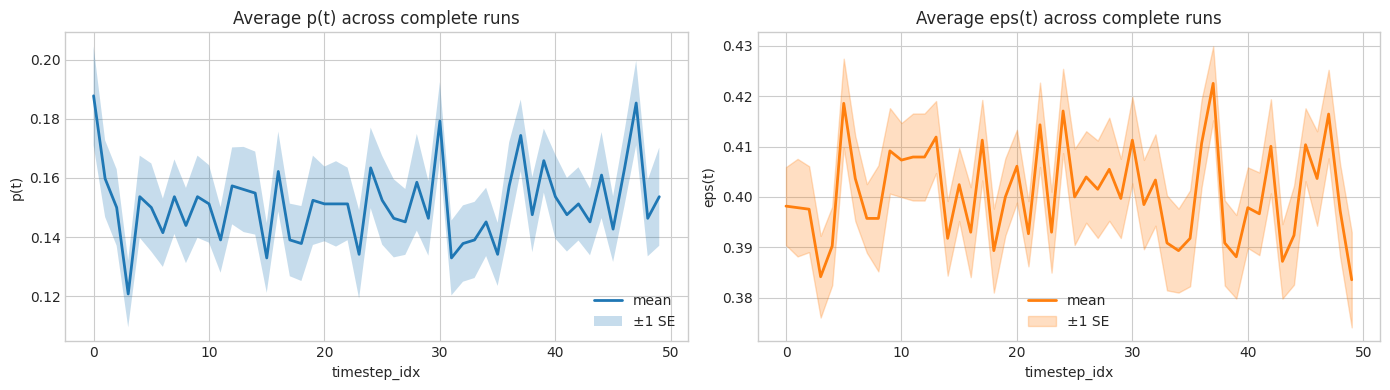

In [8]:
overall_curve = (
    step_stats.groupby('timestep_idx')
    .agg(
        p_t_mean=('p_t', 'mean'),
        p_t_se=('p_t', 'sem'),
        eps_t_mean=('eps_t', 'mean'),
        eps_t_se=('eps_t', 'sem'),
    )
    .reset_index()
)
overall_curve[['p_t_se', 'eps_t_se']] = overall_curve[['p_t_se', 'eps_t_se']].fillna(0.0)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

axes[0].plot(overall_curve['timestep_idx'], overall_curve['p_t_mean'], linewidth=2, label='mean')
axes[0].fill_between(
    overall_curve['timestep_idx'],
    overall_curve['p_t_mean'] - overall_curve['p_t_se'],
    overall_curve['p_t_mean'] + overall_curve['p_t_se'],
    alpha=0.25,
    label='±1 SE',
)
axes[0].set_title('Average p(t) across complete runs')
axes[0].set_xlabel('timestep_idx')
axes[0].set_ylabel('p(t)')
axes[0].legend()

axes[1].plot(overall_curve['timestep_idx'], overall_curve['eps_t_mean'], linewidth=2, color='tab:orange', label='mean')
axes[1].fill_between(
    overall_curve['timestep_idx'],
    overall_curve['eps_t_mean'] - overall_curve['eps_t_se'],
    overall_curve['eps_t_mean'] + overall_curve['eps_t_se'],
    color='tab:orange',
    alpha=0.25,
    label='±1 SE',
)
axes[1].set_title('Average eps(t) across complete runs')
axes[1].set_xlabel('timestep_idx')
axes[1].set_ylabel('eps(t)')
axes[1].legend()

plt.tight_layout()
plt.show()


## By prompt

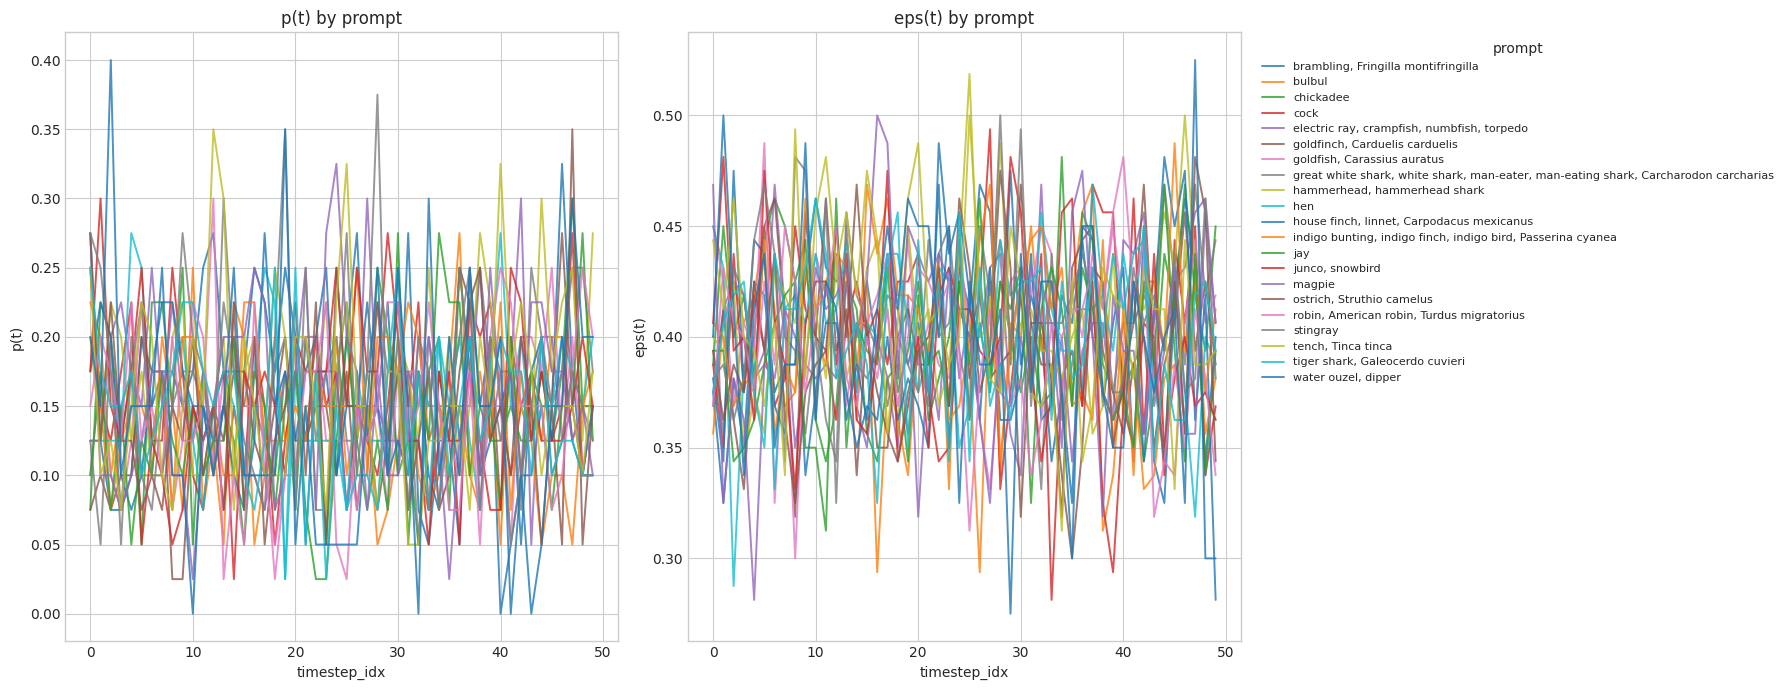

In [9]:
by_prompt_curve = step_stats.groupby(['prompt_index', 'prompt', 'timestep_idx'], as_index=False)[['p_t', 'eps_t']].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True)
for prompt, group in by_prompt_curve.groupby('prompt'):
    axes[0].plot(group['timestep_idx'], group['p_t'], alpha=0.8, linewidth=1.4, label=prompt)
    axes[1].plot(group['timestep_idx'], group['eps_t'], alpha=0.8, linewidth=1.4, label=prompt)

axes[0].set_title('p(t) by prompt')
axes[0].set_xlabel('timestep_idx')
axes[0].set_ylabel('p(t)')

axes[1].set_title('eps(t) by prompt')
axes[1].set_xlabel('timestep_idx')
axes[1].set_ylabel('eps(t)')

axes[1].legend(title='prompt', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

## Separated by reward function

In [10]:
reward_fn_counts = analysis_meta.groupby('reward_fn')['run_file'].count().rename('num_complete_runs').reset_index()
reward_fn_counts

,reward_fn,num_complete_runs
0,clip,41


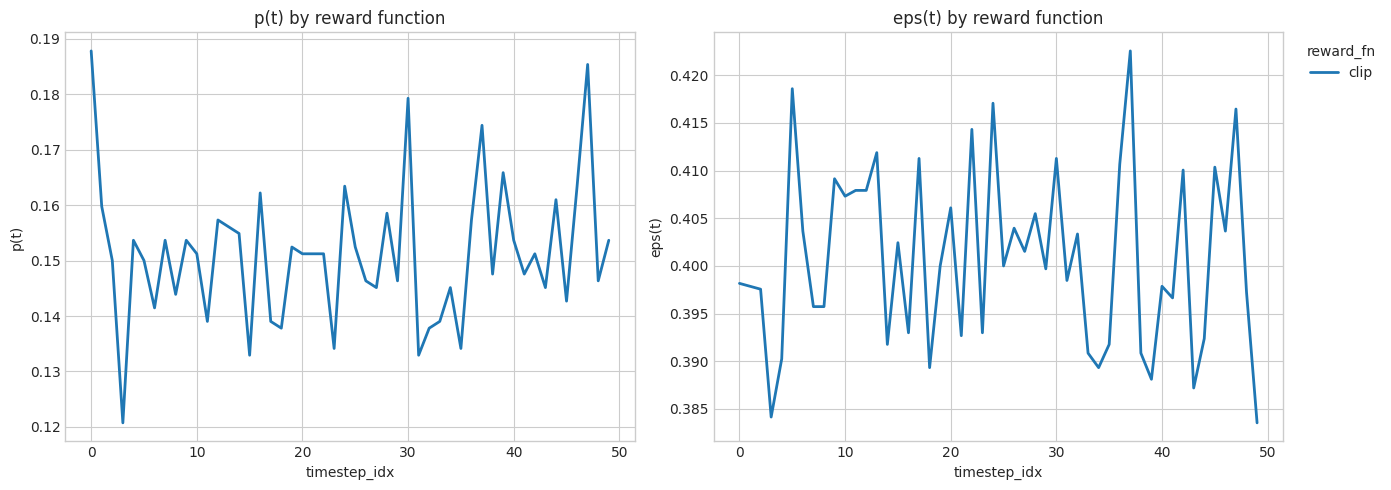

In [11]:
by_reward_fn_curve = step_stats.groupby(['reward_fn', 'timestep_idx'], as_index=False)[['p_t', 'eps_t']].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
for rf, group in by_reward_fn_curve.groupby('reward_fn', sort=True):
    axes[0].plot(group['timestep_idx'], group['p_t'], linewidth=2, label=str(rf))
    axes[1].plot(group['timestep_idx'], group['eps_t'], linewidth=2, label=str(rf))

axes[0].set_title('p(t) by reward function')
axes[0].set_xlabel('timestep_idx')
axes[0].set_ylabel('p(t)')

axes[1].set_title('eps(t) by reward function')
axes[1].set_xlabel('timestep_idx')
axes[1].set_ylabel('eps(t)')

axes[1].legend(title='reward_fn', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Global Beats Incumbent
We have per-candidate scores in `candidate_eval.score`.

Definition used here:
- At fixed `(run_file, sample_idx, timestep_idx, local_iter_idx)`, let incumbent be the best `winner_score` seen in prior local iterations within the same timestep.
- We count a hit if `max(score of global candidates at this local iteration) > incumbent`.

Note: local iteration 0 has no prior incumbent and is excluded.

In [12]:
# Build group-level frame for incumbent analysis
group_df = (
    analysis_df
    .groupby(['run_file', 'sample_idx', 'timestep_idx', 'local_iter_idx'], as_index=False)
    .agg(
        winner_score=('winner_score', 'first'),
        best_global_score=('score', lambda s: s[analysis_df.loc[s.index, 'is_global_candidate']].max() if analysis_df.loc[s.index, 'is_global_candidate'].any() else float('nan'))
    )
    .sort_values(['run_file', 'sample_idx', 'timestep_idx', 'local_iter_idx'])
    .reset_index(drop=True)
)

# Incumbent = prior running max winner_score within each (run_file, sample_idx, timestep_idx)
group_df['incumbent_before_iter'] = (
    group_df
    .groupby(['run_file', 'sample_idx', 'timestep_idx'])['winner_score']
    .transform(lambda s: s.cummax().shift(1))
)

check_df = group_df.dropna(subset=['incumbent_before_iter']).copy()
check_df['global_beats_incumbent'] = check_df['best_global_score'] > check_df['incumbent_before_iter']
check_df.head()

,run_file,sample_idx,timestep_idx,local_iter_idx,winner_score,best_global_score,incumbent_before_iter,global_beats_incumbent
1,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,0,0,1,0.181884,0.172266,0.180241,False
2,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,0,0,2,0.179460,0.165318,0.181884,False
3,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,0,0,3,0.180304,0.169315,0.181884,False
4,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,0,0,4,0.182493,0.172599,0.181884,False
5,sd_clip_epsgreedy_first20_sd_eps_greedy_clip_p...,0,0,5,0.188064,0.188064,0.182493,True


In [13]:
summary_gbi = {
    'num_checks': int(len(check_df)),
    'num_hits_global_beats_incumbent': int(check_df['global_beats_incumbent'].sum()),
    'hit_rate': float(check_df['global_beats_incumbent'].mean()),
}
summary_gbi

{'num_checks': 38950,
 'num_hits_global_beats_incumbent': 3128,
 'hit_rate': 0.08030808729139922}

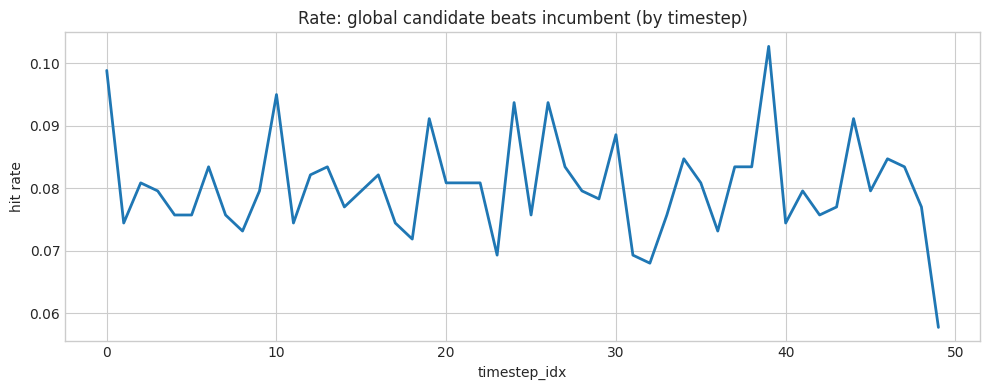

In [14]:
gbi_by_t = check_df.groupby('timestep_idx', as_index=False)['global_beats_incumbent'].mean()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(gbi_by_t['timestep_idx'], gbi_by_t['global_beats_incumbent'], linewidth=2)
ax.set_title('Rate: global candidate beats incumbent (by timestep)')
ax.set_xlabel('timestep_idx')
ax.set_ylabel('hit rate')
plt.tight_layout()
plt.show()

## k-bar (from paper)
Using the paper's notation, for each timestep `t` and local iteration `k in {1,...,K}`:
- `I_k = 1` if eps-greedy selects a random Normal candidate at iteration `k` (in logs: `winner_is_global=True`), else `0`.
- We compute `\bar{k}_t = sum_{k=1}^K (k-1) I_k`.

For `K=20`, if random is selected at every iteration, `\bar{k}_t = 190` (paper text informally references this as about 10 when scaled by 1/K).

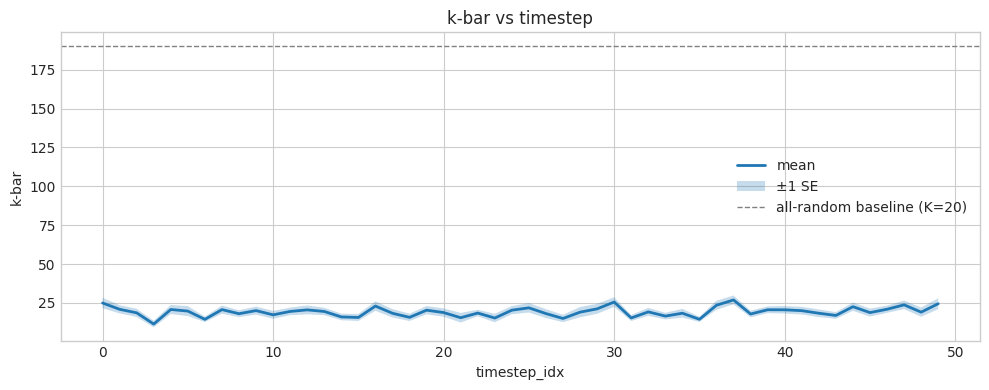

In [15]:
# One row per (run,sample,timestep,local_iter): winner_is_global is constant within each group
iter_df = (
    analysis_df
    .groupby(['run_file', 'sample_idx', 'timestep_idx', 'local_iter_idx'], as_index=False)
    .agg(
        I_k=('winner_is_global', 'first'),
        timestep_value=('timestep_value', 'first'),
    )
)

# Add K per run from run metadata
run_k = analysis_meta[['run_file', 'K']].drop_duplicates()
iter_df = iter_df.merge(run_k, on='run_file', how='left')

# local_iter_idx is 0-based and equals (k-1) in the paper's formula
iter_df['k_minus_1_times_I'] = iter_df['local_iter_idx'] * iter_df['I_k'].astype(float)

kbar_per_run_t = (
    iter_df
    .groupby(['run_file', 'sample_idx', 'timestep_idx'], as_index=False)
    .agg(
        kbar_num=('k_minus_1_times_I', 'sum'),
        K=('K', 'first'),
        timestep_value=('timestep_value', 'first'),
    )
)
kbar_per_run_t['k_bar'] = kbar_per_run_t['kbar_num']

kbar_curve = (
    kbar_per_run_t.groupby('timestep_idx', as_index=False)
    .agg(k_bar_mean=('k_bar', 'mean'), k_bar_se=('k_bar', 'sem'))
)
kbar_curve['k_bar_se'] = kbar_curve['k_bar_se'].fillna(0.0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(kbar_curve['timestep_idx'], kbar_curve['k_bar_mean'], linewidth=2, label='mean')
ax.fill_between(
    kbar_curve['timestep_idx'],
    kbar_curve['k_bar_mean'] - kbar_curve['k_bar_se'],
    kbar_curve['k_bar_mean'] + kbar_curve['k_bar_se'],
    alpha=0.25,
    label='±1 SE',
)
ax.axhline(190, color='gray', linestyle='--', linewidth=1, label='all-random baseline (K=20)')
ax.set_title('k-bar vs timestep')
ax.set_xlabel('timestep_idx')
ax.set_ylabel('k-bar')
ax.legend()
plt.tight_layout()
plt.show()